In [1]:
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
moons = sklearn.datasets.make_moons(random_state=42, noise=.15, n_samples=1000)

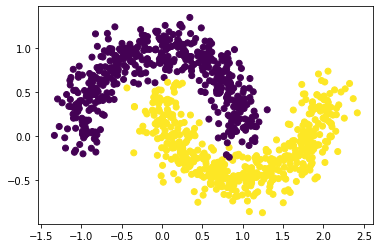

In [3]:
plt.scatter(*moons[0].T, c=moons[1])

In [4]:
import geoopt
import torch
ball = geoopt.PoincareBall()

In [5]:
points = torch.from_numpy(moons[0])
points -= points.mean(0, keepdims=True)
points = ball.expmap0(points)
labels = torch.from_numpy(moons[1])

In [6]:
points

tensor([[-0.5140,  0.2096],
        [ 0.4772, -0.5076],
        [ 0.3082, -0.3498],
        ...,
        [ 0.7769, -0.4080],
        [-0.9028, -0.0282],
        [ 0.2638,  0.3534]], dtype=torch.float64)

In [7]:
import torch.nn as nn
import numpy as np
import geoopt_layers.poincare as hnn
import tqdm
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, input):
        return self.func(input)


In [33]:
classifier = nn.Sequential(
    hnn.Distance2PoincareHyperplanes(plane_shape=2, num_planes=4, squared=False, ball=ball.float()),
    nn.Linear(4, 10),
    nn.Softmax(dim=1),
    hnn.WeightedPoincareCentroids(3, 10, ball=ball),
    hnn.Distance2PoincareHyperplanes(3, 2, squared=False, ball=ball),
    nn.Linear(2, 1)
).double()

In [34]:
optim = geoopt.optim.RiemannianAdam(classifier.parameters(), lr=1e-3)

In [35]:
data = torch.utils.data.TensorDataset(points, labels)
loader = torch.utils.data.DataLoader(data, 100)
criterion = torch.nn.BCEWithLogitsLoss()

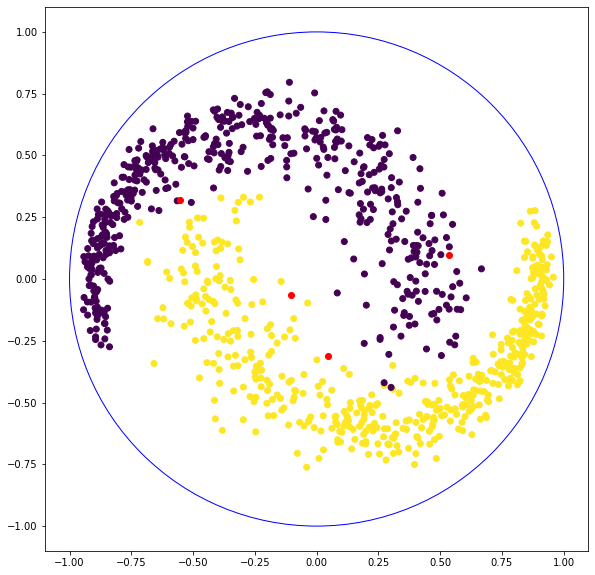

In [36]:
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, fill=False, color="b")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
plt.scatter(*points.t(), c=labels)
plt.scatter(*classifier[0].points.t().data, color="r")

In [37]:
with tqdm.trange(300) as _range:
    for epoch in _range:
        for p, l in loader:
            optim.zero_grad()
            logits = classifier(p)
            loss = criterion(logits.view(-1), l.float())
            loss.backward()
            optim.step()
            _range.set_description(f"loss={loss.item()}")

loss=0.06317204236984253: 100%|██████████| 300/300 [00:36<00:00,  8.23it/s] 


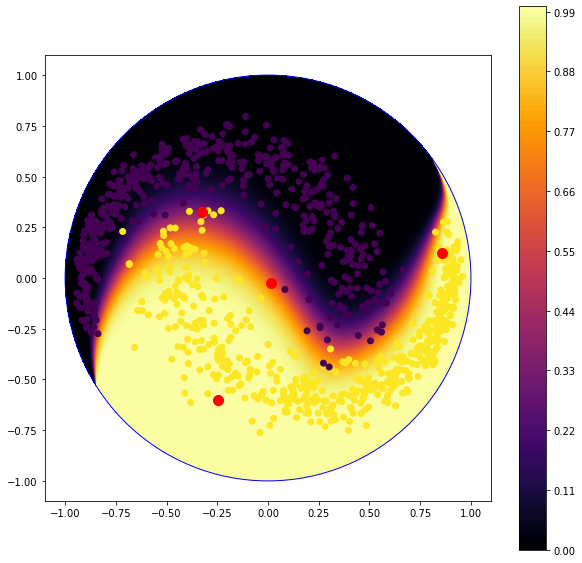

In [38]:
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, fill=False, color="b")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
radius = 1.
coords = torch.linspace(-radius, radius, 1000, dtype=torch.double)
xx, yy = torch.meshgrid(coords, coords)
dist2 = xx ** 2 + yy ** 2
mask = dist2 <= radius ** 2
grid = torch.stack([xx, yy], dim=-1)
logits = classifier(grid.view(-1, 2)).reshape(xx.shape)
logits[~mask] = np.nan
plt.contourf(
    grid[..., 0], grid[..., 1], logits.sigmoid().detach().numpy(), levels=100, cmap="inferno"
)
plt.colorbar()
plt.scatter(*points.t(), c=labels)
plt.scatter(*classifier[0].points.t().data, color="r", marker="o", s=100)
